## Group project 

In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme(style="darkgrid")
random.seed(10)
import math
import scipy.stats

/Users/polinab/.virtualenvs/base/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Generate the synthetic data set 

In [2]:
bernoulli = random.random()
print(f'Random bernoulli variable is assigned as {bernoulli}')
x = np.random.uniform(0, 10, 1000)
label = np.random.binomial(1, bernoulli, 1000)
noise_a = np.random.normal(0, 1, 1000) 
noise_b = np.random.normal(0, 3, 1000)
d = {'x': x, 'label': label, 'noise_a': noise_a, 'noise_b': noise_b}
df = pd.DataFrame(data=d)
df.loc[df.label == 0, 'y'] = df.x * 3 + 2 + df.noise_a
df.loc[df.label == 1, 'y'] = df.x * 4 + 4 + df.noise_b
df

Random bernoulli variable is assigned as 0.5714025946899135


,x,label,noise_a,noise_b,y
0,5.150760,1,-0.701112,-2.754436,21.848606
1,4.810847,1,-0.068789,-3.331650,19.911736
2,1.111050,1,1.517471,7.317836,15.762036
3,0.608445,0,-0.317301,0.864326,3.508034
4,4.897261,1,-1.555106,-0.770379,22.818665
...,...,...,...,...,...
995,3.788841,0,0.645427,3.486171,14.011951
996,3.289258,0,-0.610905,7.042898,11.256868
997,5.317132,1,-1.231161,4.445525,29.714052
998,5.453903,1,0.152976,-0.228462,25.587152


## Plotting the data for a first overview 

<AxesSubplot:xlabel='x', ylabel='y'>

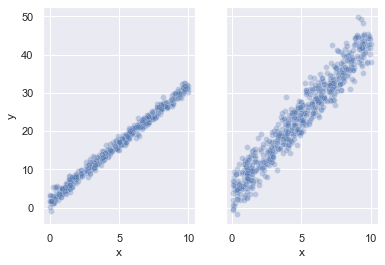

In [3]:
fig, ax =plt.subplots(1,2, sharey=True)
sns.scatterplot(data=df[df.label == 0],x='x', y='y', alpha=0.3,ax=ax[0])
sns.scatterplot(data=df[df.label == 1],x='x', y='y', alpha=0.3,ax=ax[1])


<AxesSubplot:xlabel='x', ylabel='y'>

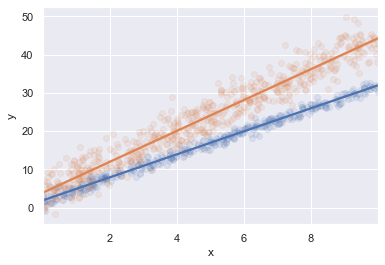

In [4]:
sns.regplot(data=df[df.label == 0],x='x', y='y',scatter_kws={'alpha':0.1})
sns.regplot(data=df[df.label == 1],x='x', y='y',scatter_kws={'alpha':0.1})


<AxesSubplot:xlabel='x', ylabel='Density'>

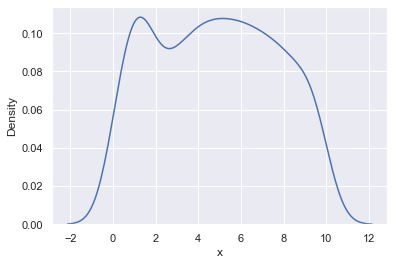

In [5]:
sns.kdeplot(data=df.x)

# Second part: mathematical background 

To Do !

# Third part: Implementation of the EM algorithm 

## Initialization 

In [6]:
# initialization of the parameter
variance_a = random.randint(1, 3) #needs to be >= 0
variance_b = random.randint(1, 3) #needs to be >= 0

beta_a0 = beta_b0 = 0.5
beta_a1 = beta_b1 = 1
prob_a = 0.76
prob_b = 1 - prob_a

# parameter_list = [beta_a0,beta_a1,variance_a,variance_b,beta_b0,beta_b1,prob_a,prob_b]
# parameter_list

params = {
    'variance_a':variance_a,
    'variance_b': variance_b,
    'beta_a0':beta_a0,
    'beta_a1':beta_a1,
    'beta_b0':beta_b0,
    'beta_b1':beta_b1,
    'prob_a':prob_a,
    'prob_b':prob_b
    
}



## Setting the weights 

In [7]:
w_a_numerator  = prob_a * (1/np.sqrt(2*np.pi*variance_a)) * np.exp((-(1/(2*variance_a)) * (df.y - beta_a0 - beta_a1*df.x)**2))
w_b_numerator = prob_b * (1/np.sqrt(2*np.pi*variance_b)) * np.exp((-(1/(2*variance_b)) * (df.y - beta_b0 - beta_b1*df.x)**2))

w_sum = w_a_numerator + w_b_numerator
print(w_a_numerator[0], w_b_numerator[0],w_sum[0])
w_a = w_a_numerator/w_sum
w_b = w_b_numerator/w_sum

6.994000322768162e-30 2.2086316808741563e-30 9.202632003642319e-30


In [8]:
w_data = pd.DataFrame(data = {'w_a':w_a,'w_b':w_b})
w_data.head()

,w_a,w_b
0,0.76,0.24
1,0.76,0.24
2,0.76,0.24
3,0.76,0.24
4,0.76,0.24


## Expectation step

In [9]:
##Expectation step
def Estep(p):
   
    #Set the values for the algorithm
    w_a_numerator  = p['prob_a'] * (1/np.sqrt(2*np.pi*p['variance_a'])) * np.exp((-(1/(2*p['variance_a'])) * (df.y - p['beta_a0'] - p['beta_a1']*df.x)**2))
    w_a_numerator  = p['prob_b'] * (1/np.sqrt(2*np.pi*p['variance_b'])) * np.exp((-(1/(2*p['variance_b'])) * (df.y - p['beta_b0'] - p['beta_b1']*df.x)**2))
    p['w_sum'] = w_a_numerator + w_b_numerator
    p['w_a'] = w_a_numerator/w_sum
    p['w_b'] = w_b_numerator/w_sum
    
    return p


## Maximisation step

In [10]:
## Maximisation step:
def Mstep(p, df):

    #Update the function following the derived update rules:
    
    #Update the prior beliefs
    p['prob_a'] = p['w_a'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    p['prob_b'] = p['w_b'].sum()/(p['w_a'].sum() +p['w_b'].sum()).sum()
    
    #Update the betas for each subgroup
    #Beta_0
    
    p['beta_a0'] = ((df.y - p['beta_a1']*df.x)*p['w_a']).sum()/p['w_a'].sum() 
    p['beta_b0'] = ((df.y - p['beta_b1']*df.x)*p['w_b']).sum()/p['w_b'].sum() 
  
    #New beta formula
    p['beta_a1'] = ((df.y*df.x - p['beta_a0']*df.x)*p['w_a']).sum()/(p['w_a']*df.x**2).sum() 
    p['beta_b1'] = ((df.y*df.x - p['beta_b0']*df.x)*p['w_b']).sum()/(p['w_b']*df.x**2).sum() 
    #print('beta1', beta_a1, beta_b1)
    
    #Update the variance 
    #Define the residuals first
    e_hat_a = df.y - p['beta_a0']-p['beta_a1']*df.x
    e_hat_b = df.y - p['beta_b0']-p['beta_b1']*df.x
    #print('ehat', e_hat_a, e_hat_b)
    
    #Define the variance 

    p['variance_a'] = ((e_hat_a**2)*p['w_a']).sum()/p['w_a'].sum()
    p['variance_b'] = ((e_hat_b**2)*p['w_b']).sum()/p['w_b'].sum()

    return p
    

In [11]:
Mstep(Estep(params),df)


{'variance_a': 60.2436542198581,
 'variance_b': 60.2436542198581,
 'beta_a0': 15.626384895897411,
 'beta_a1': 1.6791870547392538,
 'beta_b0': 15.626384895897411,
 'beta_b1': 1.6791870547392538,
 'prob_a': 0.5,
 'prob_b': 0.5,
 'w_sum': 0      4.417263e-30
 1      9.666350e-25
 2      2.453151e-23
 3      3.209713e-02
 4      1.509958e-34
            ...     
 995    7.365645e-12
 996    1.194006e-07
 997    1.346736e-63
 998    1.907068e-43
 999    4.917307e-11
 Length: 1000, dtype: float64,
 'w_a': 0      0.24
 1      0.24
 2      0.24
 3      0.24
 4      0.24
        ... 
 995    0.24
 996    0.24
 997    0.24
 998    0.24
 999    0.24
 Length: 1000, dtype: float64,
 'w_b': 0      0.24
 1      0.24
 2      0.24
 3      0.24
 4      0.24
        ... 
 995    0.24
 996    0.24
 997    0.24
 998    0.24
 999    0.24
 Length: 1000, dtype: float64}

## Defining the average likelihood function

In [12]:
def get_avg_log_likelihood(p,df):
    
    Q_function_a = -1/2*((p['w_a']*((df.y-p['beta_a0']-p['beta_a1']*df.x)**2-math.log(p['variance_a']))).sum())
    Q_function_b = -1/2*((p['w_b']*((df.y-p['beta_b0']-p['beta_b1']*df.x)**2-math.log(p['variance_b']))).sum())
    
    Q_function = Q_function_a + Q_function_b
    
    return Q_function

In [13]:
def run_em(p,df):
    avg_loglikelihoods = []
    while True: 
        #re-initialize parameters
        p['variance_a'] = random.randint(1, 3) #needs to be >= 0
        p['variance_b'] = random.randint(1, 3) #needs to be >= 0
        p['beta_a0'] = p['beta_b0'] = random.random()
        p['beta_a1'] = p['beta_b1'] = random.randint(0,10)
        p['prob_a'] = random.random()
        p['prob_b'] = 1 - p['prob_a']
        
        #Estimation step
        p = Mstep(Estep(p),df)
                
        #Evaluate the loglikelihood function
        avg_loglikelihood = get_avg_log_likelihood(p,df)
        avg_loglikelihoods.append(avg_loglikelihood)
        slope = 1/avg_loglikelihood
        if len(avg_loglikelihoods)>2 and (avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0:
            break
        if len(avg_loglikelihoods) > 2 and abs(avg_loglikelihoods[-1] - avg_loglikelihoods[-2]) < 0.0001: #Define a stopping criterion
            break
    
    return p, avg_loglikelihoods


In [14]:
new_params, log_likelies = run_em(params, df)

In [15]:
log_likelies

[-2.703862705246513e+136,
 -1.0912691770448604e+138,
 -251242321.30135635,
 -3.770915671122152e+175]

## Plotting the iterations 

In [16]:
iterations = np.arange(0,len(log_likelies),1)
data_log = pd.DataFrame(data={'logs': log_likelies, 'iterations': iterations})

In [17]:
data_log

,logs,iterations
0,-2.703863e+136,0
1,-1.091269e+138,1
2,-2.512423e+08,2
3,-3.770916e+175,3


<AxesSubplot:xlabel='iterations', ylabel='logs'>

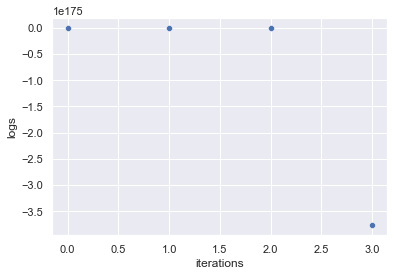

In [18]:
sns.scatterplot(x = 'iterations', y = 'logs', data = data_log)